In [1]:
import os
import time
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt
from torch.autograd import grad
from torch.distributions.uniform import Uniform
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torchinfo import summary
from rich.progress import Progress
from rich.console import Console
from rich.table import Table

In [2]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.total_images = len(os.listdir(path=self.img_dir))
        self.img_paths = [os.path.join(self.img_dir, i) for i in os.listdir(path=self.img_dir)]

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        img = read_image(path=self.img_paths[idx], mode=ImageReadMode.UNCHANGED)
        
        if self.transform:
            img = self.transform(img)

        return img

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(kernel_size=4, in_channels=3, out_channels=64, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),
            
            nn.Conv2d(kernel_size=4, in_channels=64, out_channels=128, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3), 
            
            nn.Conv2d(kernel_size=4, in_channels=128, out_channels=256, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),

            nn.Conv2d(kernel_size=4, in_channels=256, out_channels=512, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),

            nn.Conv2d(kernel_size=4, in_channels=512, out_channels=1, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(torch.Size([100, 1, 1]))),
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(num_features=512, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
discriminator = Discriminator()
discriminator.to(device)

summary(discriminator, input_size=[(1, 3, 64, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Dropout: 2-3                      [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 128, 16, 16]          131,072
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Dropout: 2-6                      [1, 128, 16, 16]          --
│    └─Conv2d: 2-7                       [1, 256, 8, 8]            524,288
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Dropout: 2-9                      [1, 256, 8, 8]            --
│    └─Conv2d: 2-10                      [1, 512, 4, 4]            2,097,152
│    └─LeakyReLU: 2-11                   [1, 512, 4, 4]          

In [7]:
generator = Generator()
generator.to(device)

summary(generator, input_size=[(1, 100)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Unflatten: 2-1                    [1, 100, 1, 1]            --
│    └─ConvTranspose2d: 2-2              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-3                  [1, 512, 4, 4]            1,024
│    └─LeakyReLU: 2-4                    [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-5              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-6                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-7                    [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-8              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-10                   [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-11             [1, 64, 32, 32]       

In [8]:
learning_rate_generator = 0.0002
learning_rate_discriminator = 0.0002
beta_1 = 0.5
beta_2 = 0.999
batch_size = 768
epochs = 25
gp_weight = 10
critic_steps = 3

In [9]:
discriminator_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate_discriminator, betas=(beta_1, beta_2))
generator_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate_generator, betas=(beta_1, beta_2))

In [10]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()

    def forward(self, fake_score, real_score=None):
        if real_score != None:
            return -1 * (torch.mean(real_score) - torch.mean(fake_score))
        else:
            return -1 * torch.mean(fake_score)

In [11]:
class GradientPenalty(nn.Module):
    def __init__(self, discriminator, gp_weight):
        super(GradientPenalty, self).__init__()
        self.discriminator = discriminator
        self.gp_weight = gp_weight

    def forward(self, fake_img, real_img):
        batch = fake_img.shape[0]
        alpha = torch.randn((batch, 1, 1, 1)).to(device)

        inter = (alpha * fake_img) + ((1 - alpha) * real_img).requires_grad_(True)
        score = self.discriminator(inter)
        
        grads = grad(
            outputs=score, 
            inputs=inter, 
            grad_outputs=torch.ones(score.size()).to(device), 
            create_graph=True, 
            retain_graph=True
        )[0]

        norms = torch.norm(grads.view(grads.size(0), -1), dim=1)

        return torch.mean(torch.pow((norms - 1), 2)) * self.gp_weight

In [12]:
discriminator_loss = WassersteinLoss()
generator_loss = WassersteinLoss()
gradient_penalty = GradientPenalty(discriminator=discriminator, gp_weight=gp_weight)

In [13]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
        v2.Resize((64, 64)),
    ]
)

train_dataset = CelebADataset('dataset/celeba/img_align/', transform=transform)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
def train_loop(dataloader, 
               discriminator, 
               generator, 
               discriminator_optimizer, 
               generator_optimizer, 
               discriminator_loss,
               generator_loss,
               gradient_penalty,
               current_epoch,
               total_epochs,
               critic_steps,
               device):
    start_time = time.time()
    
    total_batches = len(dataloader)
    discriminator_total_loss = 0
    generator_total_loss = 0

    with Progress() as progress:
        total_batches = progress.add_task(f'[red]Epoch {current_epoch}/{epochs}', total=total_batches)

        while not progress.finished:
            for current_batch, (current_batch_data) in enumerate(dataloader):
                current_batch_size = current_batch_data.shape[0]
                batch_size = current_batch_size
                
                # ======================
                # Discriminator Training
                # ======================
                discriminator.train()

                for _ in range(critic_steps):
                    discriminator_optimizer.zero_grad()
                    
                    current_batch_data = current_batch_data.to(device)
                    random_latent_vectors = torch.randn(size=(batch_size, 100)).to(device)
            
                    real_imgs = current_batch_data
                    fake_imgs = generator(random_latent_vectors)
            
                    real_preds = discriminator(real_imgs)
                    fake_preds = discriminator(fake_imgs.detach())
            
                    disc_loss = discriminator_loss(fake_preds, real_preds)
                    grad_pena = gradient_penalty(fake_imgs.detach(), real_imgs)
                    w_loss_gp = disc_loss + grad_pena
        
                    w_loss_gp.backward()
                    discriminator_optimizer.step()
                    
                    discriminator_total_loss += w_loss_gp.item()
        
                # ==================
                # Generator Training
                # ==================
                generator.train()
                generator_optimizer.zero_grad()
        
                fake_preds_gen = discriminator(fake_imgs)
        
                gen_loss = generator_loss(fake_preds_gen)
        
                gen_loss.backward()
                generator_optimizer.step()
        
                generator_total_loss += gen_loss.item()

                progress.update(total_batches, advance=1)
    
    avg_disc_loss = discriminator_total_loss / (len(dataloader) * 2)
    avg_genr_loss = generator_total_loss / len(dataloader)

    end_time = time.time()

    table = Table(title=f'Epoch {current_epoch} Summary')
    
    table.add_column("Discriminator Loss", justify="left", style="cyan", no_wrap=True)
    table.add_column("Generator Loss", justify="left", style="cyan", no_wrap=True)
    table.add_column("Time Taken (seconds)", justify="left", style="cyan", no_wrap=True)

    table.add_row(f'{avg_disc_loss}', f'{avg_genr_loss}', f'{end_time - start_time}')
    
    console = Console()
    console.print(table)

In [15]:
def plot_and_save_generated_images_from_noise(n, generator, current_epoch):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(size=(n, 100)).to(device)
        generated = generator(z).detach().cpu()
        grid = make_grid(generated, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')
        plt.axis("off")
        plt.savefig(f'epoch-{current_epoch}.png', bbox_inches='tight')
        plt.show()

Output()

                         Epoch 1 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -30.19542005454952 │ 10.854066926675538 │ 273.8042471408844    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 2 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -8.291200648654591 │ 2.5589787677833526 │ 274.0625116825104    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 3 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -7.979073090986772 │ 2.767156444743953 │ 273.98473954200745   │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 4 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -6.969213844248743 │ 2.3452665624773186 │ 273.9323236942291    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 5 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -6.09967762502757  │ 2.1612530691887843 │ 273.96798825263977   │
└────────────────────┴────────────────────┴──────────────────────┘

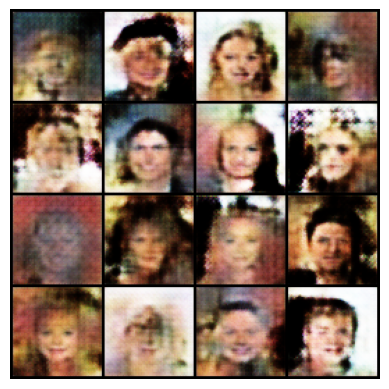

Output()

                         Epoch 6 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -6.026489549062469 │ 2.3439160113462782 │ 274.49451780319214   │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 7 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -5.941178927818934 │ 2.4527843193024057 │ 273.8898606300354    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 8 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -5.655891771569396 │ 2.4529909601886617 │ 274.0780436992645    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 9 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -5.4601845980593655 │ 2.511934023900804 │ 273.8308119773865    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 10 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -5.266982461015384 │ 2.584051246430273 │ 274.4110743999481    │
└────────────────────┴───────────────────┴──────────────────────┘

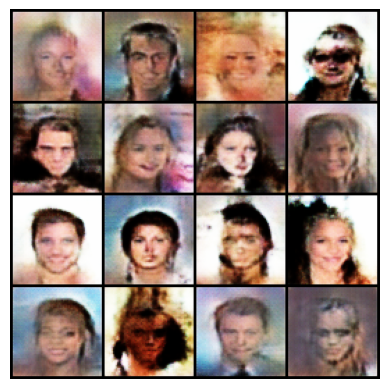

Output()

                        Epoch 11 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -5.036764950914816 │ 2.385210314172913 │ 274.07523369789124   │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 12 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -4.763736268787673 │ 2.3223698642104864 │ 277.14518427848816   │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 13 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -4.504989676629052 │ 2.2084638098621685 │ 276.45634150505066   │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 14 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -4.302530970085751 │ 2.126779538395843 │ 275.7487003803253    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 15 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -4.1186414938984495 │ 1.9421158979336421 │ 274.138142824173     │
└─────────────────────┴────────────────────┴──────────────────────┘

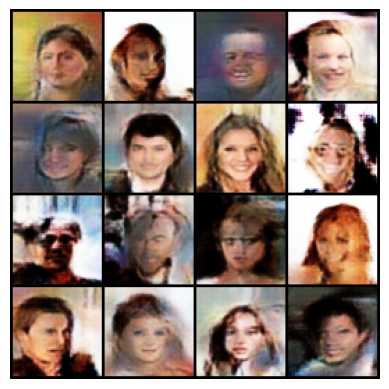

Output()

                         Epoch 16 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.9949647099005454 │ 2.034594430729295 │ 273.87896966934204   │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 17 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.943325116440202 │ 2.1422741901919697 │ 274.1990852355957    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 18 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.764115983338067 │ 1.662677318196405 │ 274.0655767917633    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 19 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.690065462706667 │ 1.9945236548894283 │ 274.13899540901184   │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 20 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.594952231555274 │ 1.7676835921346068 │ 273.98350977897644   │
└────────────────────┴────────────────────┴──────────────────────┘

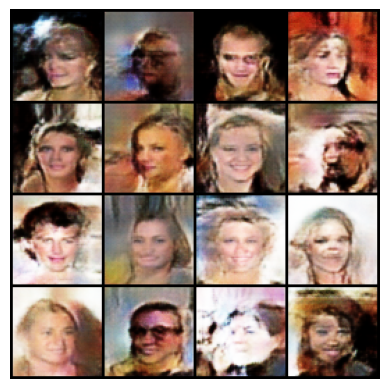

Output()

                         Epoch 21 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.6034091163539523 │ 1.5468286218996528 │ 273.98091435432434   │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 22 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.523607445824327 │ 1.6109629205117624 │ 274.0522882938385    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 23 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.3664472748271446 │ 1.7652436092475634 │ 273.9177441596985    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 24 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.2879561858646795 │ 1.3256562591184664 │ 275.7485439777374    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 25 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ -3.157882943410765 │ 1.4725044907183584 │ 270.72764563560486   │
└────────────────────┴────────────────────┴──────────────────────┘

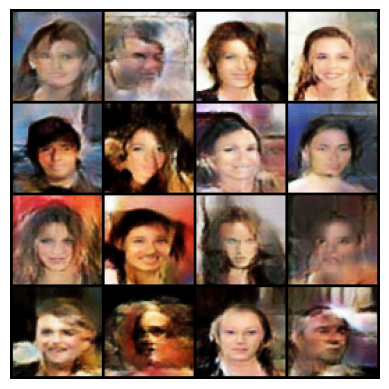

Training complete!


In [16]:
for i in range(epochs):
    train_loop(dataloader=train_data_loader, 
               discriminator=discriminator, 
               generator=generator, 
               discriminator_optimizer=discriminator_optimizer,
               generator_optimizer=generator_optimizer,
               discriminator_loss=discriminator_loss,
               generator_loss=generator_loss, 
               gradient_penalty=gradient_penalty,
               current_epoch=i + 1,
               total_epochs=epochs,
               critic_steps=critic_steps,
               device=device)
    
    if (i + 1) % 5 == 0:
        plot_and_save_generated_images_from_noise(n=16, generator=generator, current_epoch=i + 1)

print("Training complete!")